In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

In [2]:
IMAGE_SIZE = (176, 176)
BATCH_SIZE = 32
NUM_CLASSES = 4
DATASET_PATH = "./archive/Alzheimer_MRI_4_classes_dataset"  # Adjust this to the root directory of your dataset
CLASSES = ["MildDemented", "ModerateDemented", "NonDemented", "VeryMildDemented"]

In [3]:
def load_images_and_labels(dataset_path, classes):
    images = []
    labels = []
    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_path, class_name)
        for image_file in tqdm(os.listdir(class_dir), desc=f"Loading {class_name}"):
            image_path = os.path.join(class_dir, image_file)
            try:
                image = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE)
                image = tf.keras.utils.img_to_array(image)
                images.append(image)
                labels.append(idx)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(DATASET_PATH, CLASSES)

Loading VeryMildDemented: 100%|██████████| 2240/2240 [00:23<00:00, 96.13it/s] 


In [4]:
images = images / 255.0

In [5]:
images_flattened = images.reshape(images.shape[0], -1)  # Flatten images for SMOTE
smote = SMOTE()
images_resampled, labels_resampled = smote.fit_resample(images_flattened, labels)
images_resampled = images_resampled.reshape(-1, *IMAGE_SIZE, 3)  # Reshape back

In [6]:
labels_resampled = tf.keras.utils.to_categorical(labels_resampled, num_classes=NUM_CLASSES)
print(labels_resampled.shape)

(12800, 4)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(images_resampled, labels_resampled, test_size=0.2, random_state=42)

In [ ]:
# Build the Model
def build_model(input_shape=(*IMAGE_SIZE, 3)):
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        # demnet block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # demnet block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # demnet block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),
        # demnet block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Flatten and Fully Connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    return model
# Compile the Model
model = build_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

C:\Users\bende\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_462 (Conv2D)             │ (None, 176, 176, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_463 (Conv2D)             │ (None, 176, 176, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 88, 88, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_464 (Conv2D)             │ (None, 88, 88, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_465 (Conv2D)             │ (None, 88, 88, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_354         │ (None, 88, 88, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 44, 44, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_466 (Conv2D)             │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_467 (Conv2D)             │ (None, 44, 44, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_355         │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 22, 22, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_468 (Conv2D)             │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_469 (Conv2D)             │ (None, 22, 22, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_356         │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 11, 11, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_470 (Conv2D)             │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_471 (Conv2D)             │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_357         │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_106               │ (None, 5, 5, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,532,180 (17.29 MB)

 Trainable params: 4,531,220 (17.29 MB)

 Non-trainable params: 960 (3.75 KB)

In [48]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 183s 560ms/step - accuracy: 0.4685 - loss: 1.3152 - val_accuracy: 0.2586 - val_loss: 4.8792
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 201s 628ms/step - accuracy: 0.6644 - loss: 0.7056 - val_accuracy: 0.6090 - val_loss: 0.7716
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 199s 621ms/step - accuracy: 0.7190 - loss: 0.6025 - val_accuracy: 0.6348 - val_loss: 0.8774
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 215s 673ms/step - accuracy: 0.7487 - loss: 0.5574 - val_accuracy: 0.5668 - val_loss: 1.2740
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 200s 624ms/step - accuracy: 0.8016 - loss: 0.4371 - val_accuracy: 0.5785 - val_loss: 2.0304
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 199s 621ms/step - accuracy: 0.8506 - loss: 0.3490 - val_accuracy: 0.8195 - val_loss: 0.4584
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 199s 622ms/step - accuracy: 0.8940 - loss: 0.2710 - val_accuracy: 0.6453 - val_loss: 1.7443
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 199s 623ms/step - accuracy: 0.9073 -

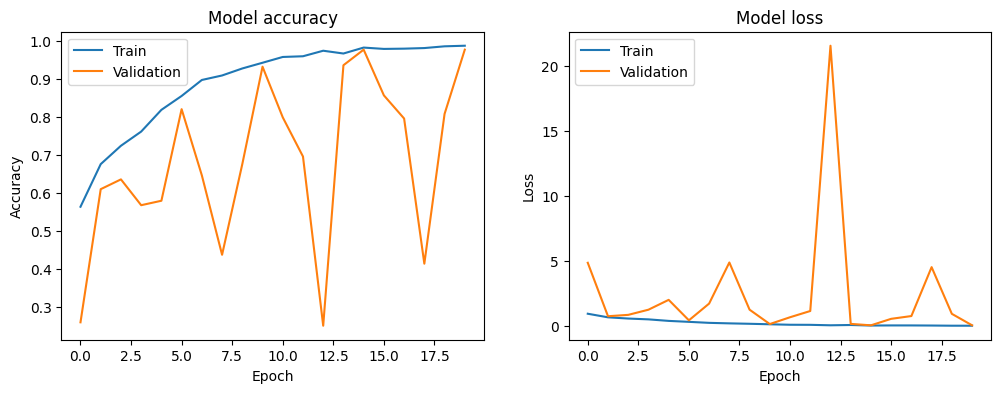

In [49]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [11]:
# Evaluate the Model
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

# Save the Model
model.save("demnet_model.h5")
print("Model saved as demnet_model.h5")

Evaluating the model...
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 191ms/step - accuracy: 0.9314 - loss: 0.2440


Validation Loss: 0.2095, Validation Accuracy: 0.9383
Model saved as demnet_model.h5


In [17]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model with pre-trained weights
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
inception_output = inception_model.layers[-1].output
inception_model = Model(inputs=inception_model.input, outputs=inception_output)

In [36]:
def build_v2_model():
    model = models.Sequential([
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense

# Adjust the input shape of the demnet_model to match the output shape of the inception_model
def build_combined_model(inception_model):
    # Make the InceptionV3 model untrainable
    inception_model.trainable = False
    
    input_layer = Input(shape=(*IMAGE_SIZE, 3))
    x = inception_model(input_layer)
    x = GlobalAveragePooling2D()(x)
    demnet_model = build_v2_model()
    output_layer = demnet_model(x)
    combined_model = Model(inputs=input_layer, outputs=output_layer)
    return combined_model

# Build and compile the combined model
combined_model = build_combined_model(inception_model)
combined_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

combined_model.summary()


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 176, 176, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_2 (Functional)       │ (None, 4, 4, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_21 (Sequential)      │ (None, 4)              │     1,123,268 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,926,052 (87.46 MB)

 Trainable params: 1,123,268 (4.28 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [41]:
# Train the combined model
history = combined_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 189s 571ms/step - accuracy: 0.4982 - loss: 1.1328 - val_accuracy: 0.6687 - val_loss: 0.7031
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 210s 656ms/step - accuracy: 0.6977 - loss: 0.6639 - val_accuracy: 0.7348 - val_loss: 0.5892
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 271s 848ms/step - accuracy: 0.7261 - loss: 0.5943 - val_accuracy: 0.7367 - val_loss: 0.5697
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 244s 761ms/step - accuracy: 0.7512 - loss: 0.5594 - val_accuracy: 0.7516 - val_loss: 0.5660
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 240s 751ms/step - accuracy: 0.7786 - loss: 0.5112 - val_accuracy: 0.7816 - val_loss: 0.5018
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 241s 753ms/step - accuracy: 0.8015 - loss: 0.4615 - val_accuracy: 0.7742 - val_loss: 0.4995
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 239s 747ms/step - accuracy: 0.8254 - loss: 0.4097 - val_accuracy: 0.7988 - val_loss: 0.4680
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 239s 749ms/step - accuracy: 0.8373 -

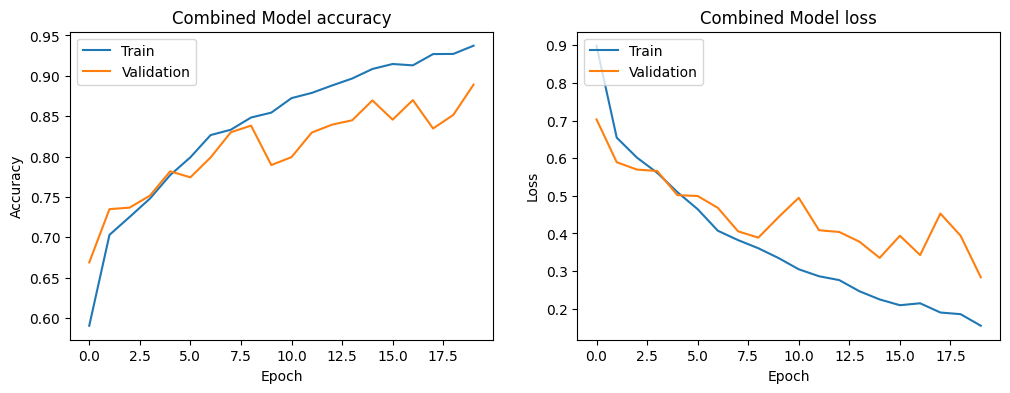

In [44]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Combined Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Combined Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Evaluating the combined model...
80/80 ━━━━━━━━━━━━━━━━━━━━ 37s 449ms/step - accuracy: 0.8716 - loss: 0.3145
Validation Loss: 0.2898, Validation Accuracy: 0.8832
80/80 ━━━━━━━━━━━━━━━━━━━━ 44s 538ms/step


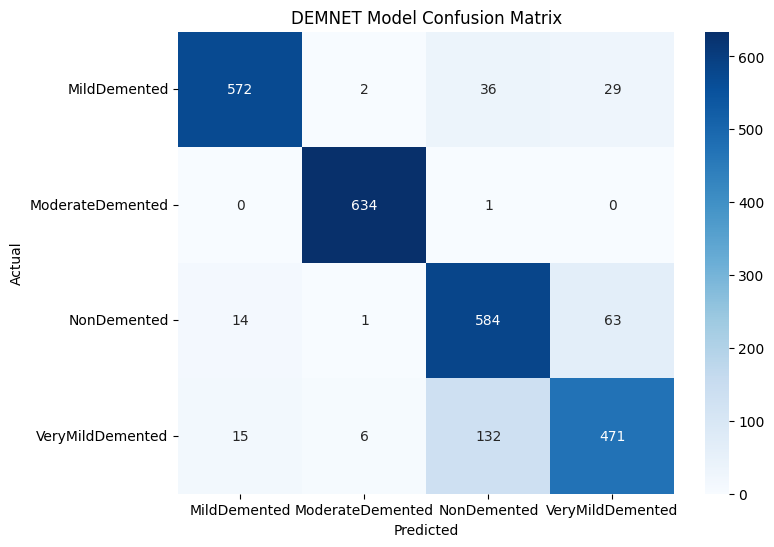

In [12]:
from tensorflow.keras.models import load_model
combined_model = load_model("combined_demnet_model.h5")
demnet_model = load_model("demnet_model.h5")

# Evaluate the combined model
print("Evaluating the combined model...")
loss, accuracy = combined_model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

y_pred = combined_model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DEMNET Model Confusion Matrix')
plt.show()






In [19]:
from tensorflow.keras.applications import VGG16
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load a pre-trained model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
feature_extractor = models.Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features = feature_extractor.predict(images)

# Flatten the features
features_flattened = features.reshape(features.shape[0], -1)

# Apply SMOTE on the flattened features
smote = SMOTE()
features_resampled, labels_resampled = smote.fit_resample(features_flattened, labels)

# Reshape the features back to the original shape
features_resampled = features_resampled.reshape(-1, *features.shape[1:])

# One-hot encode the labels
labels_resampled = tf.keras.utils.to_categorical(labels_resampled, num_classes=NUM_CLASSES)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=42)

200/200 ━━━━━━━━━━━━━━━━━━━━ 484s 2s/step


In [20]:
# train a simple model on the extracted features
model = models.Sequential([
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax'),
])
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
print(X_train.shape, y_train.shape)


(10240, 5, 5, 512) (10240, 4)


In [21]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5411 - loss: 1.1241 - val_accuracy: 0.7895 - val_loss: 0.4807
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8027 - loss: 0.4575 - val_accuracy: 0.8418 - val_loss: 0.3605
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.8557 - loss: 0.3432 - val_accuracy: 0.8691 - val_loss: 0.3175
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9008 - loss: 0.2400 - val_accuracy: 0.8973 - val_loss: 0.2482
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9209 - loss: 0.1966 - val_accuracy: 0.9129 - val_loss: 0.2174
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9482 - loss: 0.1396 - val_accuracy: 0.9219 - val_loss: 0.1802
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9426 - loss: 0.1544 - val_accuracy: 0.9465 - val_loss: 0.1440
Epoch 8/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9665 - loss: 0.0899 - 

In [22]:
# calculate the accuracy
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9739 - loss: 0.0743
Test Loss: 0.0754, Test Accuracy: 0.9750


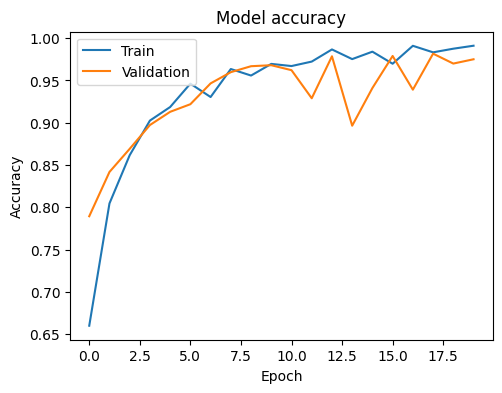

In [23]:
# plot the accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


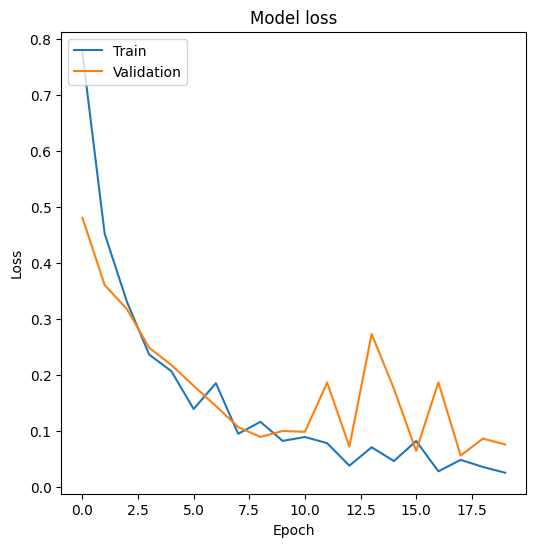

In [25]:
# create a loss plot
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


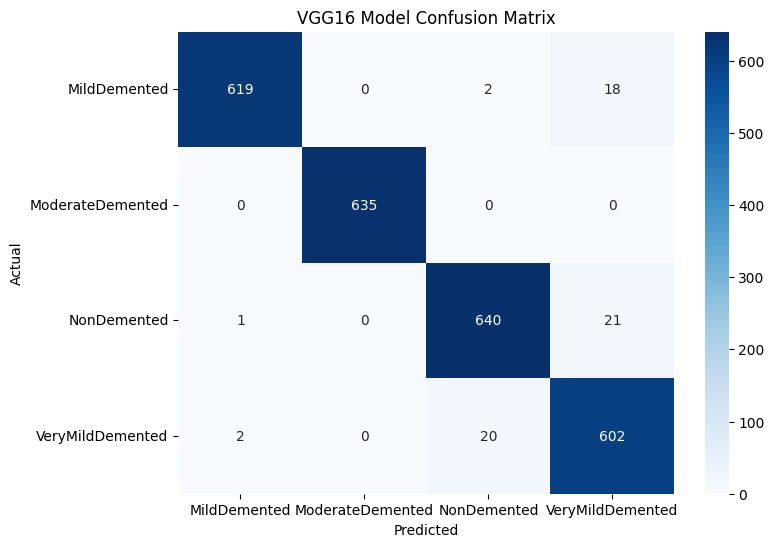

In [26]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('VGG16 Model Confusion Matrix')
plt.show()
